# Knowledge graph preparation

In [2]:
!wget https://dgl-data.s3-us-west-2.amazonaws.com/dataset/DRKG/drkg.tar.gz

--2021-10-18 11:27:57--  https://dgl-data.s3-us-west-2.amazonaws.com/dataset/DRKG/drkg.tar.gz
Resolving dgl-data.s3-us-west-2.amazonaws.com (dgl-data.s3-us-west-2.amazonaws.com)... 52.218.181.145
Connecting to dgl-data.s3-us-west-2.amazonaws.com (dgl-data.s3-us-west-2.amazonaws.com)|52.218.181.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216650245 (207M) [application/x-tar]
Saving to: ‘drkg.tar.gz’

drkg.tar.gz         100%[===================>] 206.61M  34.4MB/s    in 6.6s    

2021-10-18 11:28:04 (31.5 MB/s) - ‘drkg.tar.gz’ saved [216650245/216650245]



In [3]:
!tar -xvzf drkg.tar.gz

._drkg.tsv
drkg.tsv
._embed
embed/
embed/DRKG_TransE_l2_relation.npy
embed/._relations.tsv
embed/relations.tsv
embed/._entities.tsv
embed/entities.tsv
embed/Readme.md
embed/mol_edgepred.npy
embed/mol_infomax.npy
embed/mol_masking.npy
embed/mol_contextpred.npy
embed/DRKG_TransE_l2_entity.npy
._entity2src.tsv
entity2src.tsv
._relation_glossary.tsv
relation_glossary.tsv


In [222]:
import pandas as pd

In [223]:
df = pd.read_csv("drkg.tsv", sep="\t", header=None)

In [226]:
len(df)

5874261

In [227]:
# Switch drug IDs and remove deprecated drugs as specified by DRKG authors

df.replace(to_replace="Compound::DB05073", value="Compound::DB02709", inplace=True)
df = df.loc[~(df[0].str.contains('Compound::DB05697|Compound::DB06517|Compound::DB15351', regex=True) | df[2].str.contains('Compound::DB05697|Compound::DB06517|Compound::DB15351', regex=True))]
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [228]:
len(df)

5874247

In [229]:
# Remove all triples of the DrugBank ddi-interactor-in relation
df = df.loc[~df[1].str.contains('DRUGBANK::ddi-interactor-in::Compound:Compound')]

In [230]:
len(df)

4494987

In [ ]:
# Shuffle data and split into training, validation, and test set

shuffled_df = df.sample(frac=1)

num_train = int(len(df) * 0.95)
num_valid = int(len(df) * 0.025)

with open("drkg/train.txt", 'w+') as f:
    for i in range(0, num_train):
        row = shuffled_df.iloc[i, :]
        f.writelines("{}\t{}\t{}\n".format(row[0], row[1], row[2]))
        
with open("drkg/valid.txt", 'w+') as f:
    for i in range(num_train, num_train + num_valid):
        row = shuffled_df.iloc[i, :]
        f.writelines("{}\t{}\t{}\n".format(row[0], row[1], row[2]))

with open("drkg/test.txt", 'w+') as f:
    for i in range(num_train + num_valid, len(shuffled_df)):
        row = shuffled_df.iloc[i, :]
        f.writelines("{}\t{}\t{}\n".format(row[0], row[1], row[2]))

In [141]:
len(df[0].unique())

56641

In [142]:
len(df[1].unique())

106

In [144]:
len(df[2].unique())

75443

In [149]:
len(pd.concat([df[0], df[2]]).unique())

96768

In [169]:
# Produce unique IDs for entities
pd.Series(pd.concat([df[0], df[2]]).unique()).to_csv("drkg/entities.dict", sep="\t")

In [170]:
# Produce unique IDs for relations
pd.Series(df[1].unique()).to_csv("drkg/relations.dict", sep="\t")

# Drug repurposing analysis

In [173]:
!git clone https://github.com/gnn4dr/DRKG.git

Cloning into 'DRKG'...
remote: Enumerating objects: 291, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 291 (delta 51), reused 80 (delta 45), pack-reused 188
Receiving objects: 100% (291/291), 19.72 MiB | 15.04 MiB/s, done.
Resolving deltas: 100% (130/130), done.


In [389]:
import pandas as pd

# Read file of small molecule drugs from DRKG
candidate_drugs = pd.read_csv("DRKG/drug_repurpose/infer_drug.tsv", header=None, names=["drug", "id"], sep="\t")["drug"].tolist()

In [390]:
len(candidate_drugs)

8104

In [99]:
# Compile treatments to be tested to identify top drug recommendations
treatments = ['GNBR::N::Compound:Gene', 'DRUGBANK::target::Compound:Gene', 'DGIDB::INHIBITOR::Gene:Compound']

In [7]:
import numpy as np

# Load trained embeddings from files
ent_emb = np.load('embed/RotatE_drkg_0/entity_embedding.npy')
rel_emb = np.load('embed/RotatE_drkg_0/relation_embedding.npy')

In [8]:
ent_emb.shape

(96768, 1000)

In [9]:
rel_emb.shape

(106, 500)

In [10]:
# Create mappings of unique IDs to DRKG names

id_to_ent = pd.read_csv('drkg/entities.dict', header=None, index_col=0, squeeze=True, sep="\t").to_dict()
ent_to_id = pd.read_csv('drkg/entities.dict', header=None, index_col=1, squeeze=True, sep="\t").to_dict()

id_to_rel = pd.read_csv('drkg/relations.dict', header=None, index_col=0, squeeze=True, sep="\t").to_dict()
rel_to_id = pd.read_csv('drkg/relations.dict', header=None, index_col=1, squeeze=True, sep="\t").to_dict()

In [ ]:
import torch
import torch.nn.functional as F
import math

In [ ]:
# Modified RotatE score such that higher scores are "better" than lower scores
def RotatE(head, relation, tail, *, gamma=24, epsilon=2, hidden_dim=500):
    re_head, im_head = torch.chunk(head, 2, dim=-1)
    re_tail, im_tail = torch.chunk(tail, 2, dim=-1)
    
    #Make phases of relations uniformly distributed in [-pi, pi]
    phase_relation = relation / (((gamma + epsilon) / hidden_dim) / math.pi)

    re_relation = torch.cos(phase_relation)
    im_relation = torch.sin(phase_relation)

    re_score = re_head * re_relation - im_head * im_relation
    im_score = re_head * im_relation + im_head * re_relation
    re_score = re_score - re_tail
    im_score = im_score - im_tail

    score = torch.stack([re_score, im_score], dim=0)
    score = score.norm(dim=0)

    score = gamma - score.sum(dim=-1)
    return score

In [ ]:
# Loop through selected small-molecule drugs, selected treatments, and selected driver genes to identify top candidates

drug_ids = torch.as_tensor([ent_to_id[drug] for drug in candidate_drugs if drug in ent_to_id]).long()
gene_ids = torch.as_tensor([ent_to_id[gene] for gene in ["Gene::8754", "Gene::10890", "Gene::199675", "Gene::51338", "Gene::2730"]]).long()
treat_ids = torch.as_tensor([rel_to_id[treatment] for treatment in treatments])

drug_emb = torch.as_tensor(ent_emb[drug_ids])
treat_embs = [torch.as_tensor(rel_emb[treat_id]) for treat_id in treat_ids]

scores_per_gene = []
drugs_per_gene = []
for treat_id in range(len(treat_embs)):
    treat_emb=treat_embs[treat_id]
    for gene_id in gene_ids:
        gene_emb = torch.as_tensor(ent_emb[gene_id])
        if treatments[treat_id]=='DGIDB::INHIBITOR::Gene:Compound':
            score = F.logsigmoid(RotatE(gene_emb, treat_emb,
                                        drug_emb))
        else:
            score = F.logsigmoid(RotatE(drug_emb, treat_emb,
                                            gene_emb))
        scores_per_gene.append(score)
        drugs_per_gene.append(drug_ids)
rotate_scores = torch.cat(scores_per_gene)
scored_drugs = torch.cat(drugs_per_gene)

# sort scores in decending order
idx = torch.argsort(scores, descending=True)
rotate_scores = rotate_scores[idx].numpy()
scored_drugs = scored_drugs[idx].numpy()

_, unique_indices = np.unique(drugs, return_index=True)
num_scored_drugs = len(unique_indices)

In [394]:
# Small helper function to get top k scores after scores have been calculated in above cell
def get_top_k_drugs_and_scores(k):
    topk_indices = np.sort(unique_indices)[:k]
    top_drugs = drugs[topk_indices]
    top_scores = scores[topk_indices]
    return top_drugs, top_scores

In [21]:
# Create mapping from DBID (DrugBank accession number) to common name of drug and vice versa, using https://www.johnsnowlabs.com/marketplace/drugbank-vocabulary/
dbid_to_common = pd.read_csv('drugbank_vocab.csv', usecols=[0,2], index_col=0, squeeze=True).to_dict()
common_to_dbid = pd.read_csv('drugbank_vocab.csv', usecols=[0,2], index_col=1, squeeze=True).to_dict()

In [419]:
# Update vocabulary with some missing DBIDs
missing_dbids = {
    "DB08866": "Estradiol valerate/Dienogest",
    "DB01398": "Salicylic acid",
    "DB00667": "Histamine",
    "DB01361": "Troleandomycin",
    "DB00729": "Diphemanil methylsulfate",
    "DB08584": "SGX-523",
    "DB02507": "(S)-Warfarin",
    "DB05372": "Otenabant"
}
dbid_to_common.update(missing_dbids)
common_to_dbid.update({(v, k) for k, v in missing_dbids.items()})

In [420]:
# Print all drugs and their transformed scores
k = num_scored_drugs
top_drugs, top_scores = get_top_k_drugs_and_scores(k)
for i in range(k):
    dbid = id_to_ent[int(top_drugs[i])][10:]
    if len(dbid_to_common[dbid]) > 50:
        name = dbid
    else:
        name = dbid_to_common[dbid]
    score = top_scores[i]
    
    print("{0:<55.50}{1}".format(name, score))

INCB7839                                               0.9999576807022095
Ilomastat                                              0.9261221885681152
Glutathione                                            0.666426420211792
Guanosine-5'-Diphosphate                               0.6408891677856445
Fisetin                                                0.6266124844551086
Curcumin                                               0.5159533619880676
Guanosine-5'-Triphosphate                              0.4832378029823303
Phosphoaminophosphonic acid guanylate ester            0.36198586225509644
Melatonin                                              0.34772226214408875
Vitamin E                                              0.34721410274505615
Folic acid                                             0.3064723014831543
Epigallocatechin gallate                               0.2992515563964844
Cisplatin                                              0.2901060879230499
D-alpha-Tocopherol acetate          

In [436]:
# Save rankings to file
k = num_scored_drugs
top_drugs, top_scores = get_top_k_drugs_and_scores(k)
model_recs = pd.DataFrame.from_records(data=zip([dbid_to_common[id_to_ent[int(top_drugs[i])][10:]] for i in range(len(top_drugs))], top_scores), columns=["Drug", "Sigmoid-transformed Modified RotatE Score"])
model_recs.to_csv("model_recommendations.csv", index=False)

In [363]:
# Search results from https://clinicaltrials.gov/ct2/results?cond=COVID-19&age_v=&gndr=&type=Intr&rslt=&phase=3&Search=Apply
# Whittle down set of unique drugs in clinical trials to make cleaning/manipulation simpler
trial_drugs_nonunique = [i[6:].replace("β","beta") for row in pd.read_csv("SearchResults.csv", usecols=[5], squeeze=True) for i in row.split("|") if i[:4] == "Drug" and not "placebo" in i.lower()]
trial_drugs = []
for drug in trial_drugs_nonunique:
    if drug not in trial_drugs:
        trial_drugs.append(drug)
for drug in trial_drugs:
    print(drug)

Enoxaparin sodium
Unfractionated heparin
Fondapariniux
Argatroban
Rivaroxaban 10 mg
Doxycycline Tablets
Rivaroxaban 15Mg Tab
Favipiravir
Hydroxychloroquine
Azithromycin
Telmisartan arm will receive 80 mg Telmisartan twice daily plus standard care.
0.5% Povidone Iodine
0.12% Chlorhexidine Gluconate Mouth Rinse
1% Hydrogen Peroxide
0.9% Normal Saline
Umifenovir
Interferon-beta 1a
Lopinavir / Ritonavir
Single Dose of Hydroxychloroquine
Standards of Care
Interferon Beta-1A
Ivermectin 0.4mg/kg/day for 5 days
Apixaban
Chlorhexidine digluconate, povidone iodine
Lenalidomide as a 5 mg capsule PO daily, days 1, 3, and 5.
Cholecalciferol
Bivalirudin Injection
Standard treatment
Chloroquine Sulfate
Zinc Sulfate
Doxycycline
Dexamethasone
Vitamin D
ACE inhibitor, angiotensin receptor blocker
Cefditoren pivoxil 400mg
Sargramostim
Tetrandrine
Chloroquine phosphate
bamlanivimab
Prednisone
Ivermectin Tablets
Remdesivir
IMUNOR
Ivermectin
Methylprednisolone
Angiotensin Receptor Blockers
Tocilizumab
Enoxa

In [364]:
len(trial_drugs)

228

In [385]:
# after hand-cleaning/manipulation for spelling, duplication, presence in our drug vocabulary, removal of combination therapy, etc., and adding aliases from clinical trial information for drugs not present in vocabulary
trial_drugs = '''Enoxaparin
Heparin
Fondaparinux
Argatroban
Rivaroxaban
Doxycycline
Favipiravir
Hydroxychloroquine
Azithromycin
Telmisartan
Povidone-iodine
Chlorhexidine
Hydrogen peroxide
Sodium chloride
Umifenovir
Interferon beta-1a
Ivermectin
Apixaban
Lenalidomide
Cholecalciferol
Bivalirudin
Chloroquine
Zinc sulfate
Dexamethasone
Vitamin D
Cefditoren
Sargramostim
Tetrandrine
Bamlanivimab
Prednisone
Remdesivir
Methylprednisolone
Tocilizumab
Ticagrelor
Prasugrel
Clopidogrel
Crizanlizumab
Dapagliflozin
Empagliflozin
Canagliflozin
Ertugliflozin
Triazavirin
Famotidine
Quercetin
Zinc
Vitamin C
iota-Carrageenan
Human immunoglobulin G
Bromhexine
Canrenoic acid
Montelukast
Silibinin
Somatotropin
Camostat
Ravulizumab
Baricitinib
Pioglitazone
Deferoxamine
Berberine
Montmorrillonite
Fluoxetine
Carrimycin
Cyclosporine
Hydrochlorothiazide
Metolazone
Chlorthalidone
Chlorothiazide
Bendroflumethiazide
Indapamide
Amlodipine
Diltiazem
Felodipine
Nicardipine
Nifedipine
Nimodipine
Nitrendipine
Verapamil
Benazepril
Captopril
Enalapril
Fosinopril
Lisinopril
Perindopril
Quinapril
Ramipril
Trandolapril
Candesartan
Eprosartan
Irbesartan
Losartan
Olmesartan
Valsartan
Colchicine
Bismuth subsalicylate
Thromboprophylaxis
Vitamin D3
Cerebrolysin
Nicotinamide riboside
Sotrovimab
Nitazoxanide
Dexmedetomidine
Cetylpyridinium
Hypochlorite
Conestat alfa
Valproic acid
Quetiapine
Oseltamivir
Fluvoxamine
Niclosamide
Sevoflurane
Propofol
Hydrocortisone
Ceftriaxone
Moxifloxacin
Levofloxacin
Ceftaroline fosamil
Roxithromycin
Clarithromycin
Anakinra
Sarilumab
Ascorbic acid
Simvastatin
Eritoran
Apremilast
Acetylsalicylic acid
Tadalafil
Linagliptin
Insulin human
Ketamine
Ofatumumab
Glatiramer
Pirfenidone
Nintedanib
Tenecteplase
Budesonide
Lovenox
Ibuprofen
Oxygen
Upadacitinib
Abatacept
Secukinumab
Tofacitinib
Etanercept
Certolizumab pegol
Golimumab
Adalimumab
Canakinumab
Arbidol
Siponimod
Dimethyl fumarate
Teriflunomide
Icosapent ethyl
Sodium bicarbonate'''.split("\n")

In [386]:
len(trial_drugs)

153

In [387]:
trial_drugs = [td for td in trial_drugs if td in common_to_dbid]

In [388]:
len(trial_drugs)

144

In [198]:
# Print rankings and transformed scores of clinical trial drugs
for i in range(topk):
    drug = id_to_ent[int(top_drugs[i])][10:17]
    if drug in dbid_to_common and dbid_to_common[drug] in trial_drugs:
        score = top_scores[i]
        print("[{}]\t{}\t{}".format(i, dbid_to_common[drug], score, top_scores[i]))

[18]	Quercetin	0.25357750058174133
[29]	Berberine	0.2153739333152771
[40]	Cyclosporine	0.19606447219848633
[68]	Dexamethasone	0.14452245831489563
[72]	Simvastatin	0.14113177359104156
[76]	Nintedanib	0.13941927254199982
[90]	Hydrocortisone	0.13234275579452515
[97]	Deferoxamine	0.13026964664459229
[124]	Cholecalciferol	0.1107792854309082
[127]	Clarithromycin	0.10922977328300476
[128]	Chloroquine	0.10897689312696457
[158]	Verapamil	0.09410655498504639
[159]	Prednisone	0.09389879554510117
[180]	Ceftriaxone	0.08647900074720383
[187]	Tenecteplase	0.08471610397100449
[197]	Apixaban	0.08228000998497009
[198]	Lenalidomide	0.08206911385059357
[199]	Azithromycin	0.08187162131071091
[201]	Methylprednisolone	0.0809219554066658
[203]	Insulin human	0.08060222119092941
[205]	Levofloxacin	0.08019383251667023
[247]	Colchicine	0.07271717488765717
[251]	Povidone-iodine	0.07177562266588211
[266]	Clopidogrel	0.0677071213722229
[275]	Heparin	0.06571424752473831
[282]	Losartan	0.06488803029060364
[292]	Piogli

In [32]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

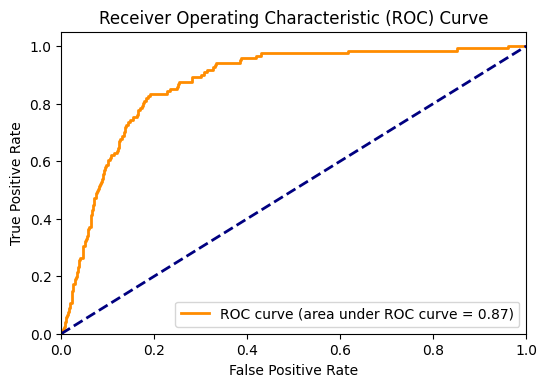

In [434]:
# Print ROC curve and calculate AUROC

top_drugs, top_scores = get_top_k_drugs_and_scores(k=num_scored_drugs)

fpr, tpr, _ = metrics.roc_curve([1 if id_to_ent[int(drug)].replace("Compound::","") in dbid_to_common and dbid_to_common[id_to_ent[int(drug)].replace("Compound::", "")] in trial_drugs else 0 for drug in top_drugs], top_scores)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(dpi=100)
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="ROC curve (area under ROC curve = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [435]:
# Plot top 100 predictions with true positives (i.e. drugs in post-training validation set of Phase IV clinical trial drugs) highlighted in blue

top_drugs, top_scores = get_top_k_drugs_and_scores(k=100)

plt.figure(dpi=2000)
plt.bar([dbid_to_common[id_to_ent[int(drug)].replace("Compound::","")] for drug in top_drugs], top_scores, color=['blue' if dbid_to_common[id_to_ent[int(drug)].replace("Compound::", "")] in trial_drugs else 'red' for drug in top_drugs])
plt.xticks(rotation = 90, fontsize=3.5)
plt.yticks(fontsize=3.5)
plt.show()

In [318]:
# Get ATC information for drugs through the knowledge graph and prepare some information for plotting

first_level_atc = df[2].str.len() == 6
atc_rels = df[1] == "DRUGBANK::x-atc::Compound:Atc"
drug_to_atc = {}
atc_df = df[atc_rels & first_level_atc]
for row in range(len(atc_df)):
    drug_to_atc[atc_df.iloc[row, 0]] = atc_df.iloc[row, 2][-1]
    
pca_drug_ids = torch.as_tensor([ent_to_id[drug] for drug in candidate_drugs if drug in ent_to_id and drug in atc_df[0].tolist()]).long()
pca_drug_emb = torch.as_tensor(ent_emb[pca_drug_ids])

color_map = {
    "A": "xkcd:black",
    "B": "xkcd:blue",
    "C": "xkcd:green",
    "D": "xkcd:brown",
    "G": "xkcd:red",
    "H": "xkcd:orange",
    "J": "xkcd:pink",
    "L": "xkcd:purple",
    "M": "xkcd:yellow",
    "N": "xkcd:maroon",
    "P": "xkcd:grey",
    "R": "xkcd:tan",
    "S": "xkcd:darkblue",
    "V": "xkcd:darkgreen"
}
colors = [color_map[drug_to_atc[id_to_ent[int(drug)]]] for drug in pca_drug_ids]

atc_map = {
    "A": "Alimentary tract and metabolism",
    "B": "Blood and blood forming organs",
    "C": "Cardiovascular system",
    "D": "Dermatologicals",
    "G": "Genito-urinary system and sex hormones",
    "H": "Systemic hormonal preparations, excluding sex hormones and insulins",
    "J": "Antiinfectives for systemic use",
    "L": "Antineoplastic and immunomodulating agents",
    "M": "Musculo-skeletal system",
    "N": "Nervous system",
    "P": "Antiparasitic products, insecticides and repellents",
    "R": "Respiratory system",
    "S": "Sensory organs",
    "V": "Various"
}

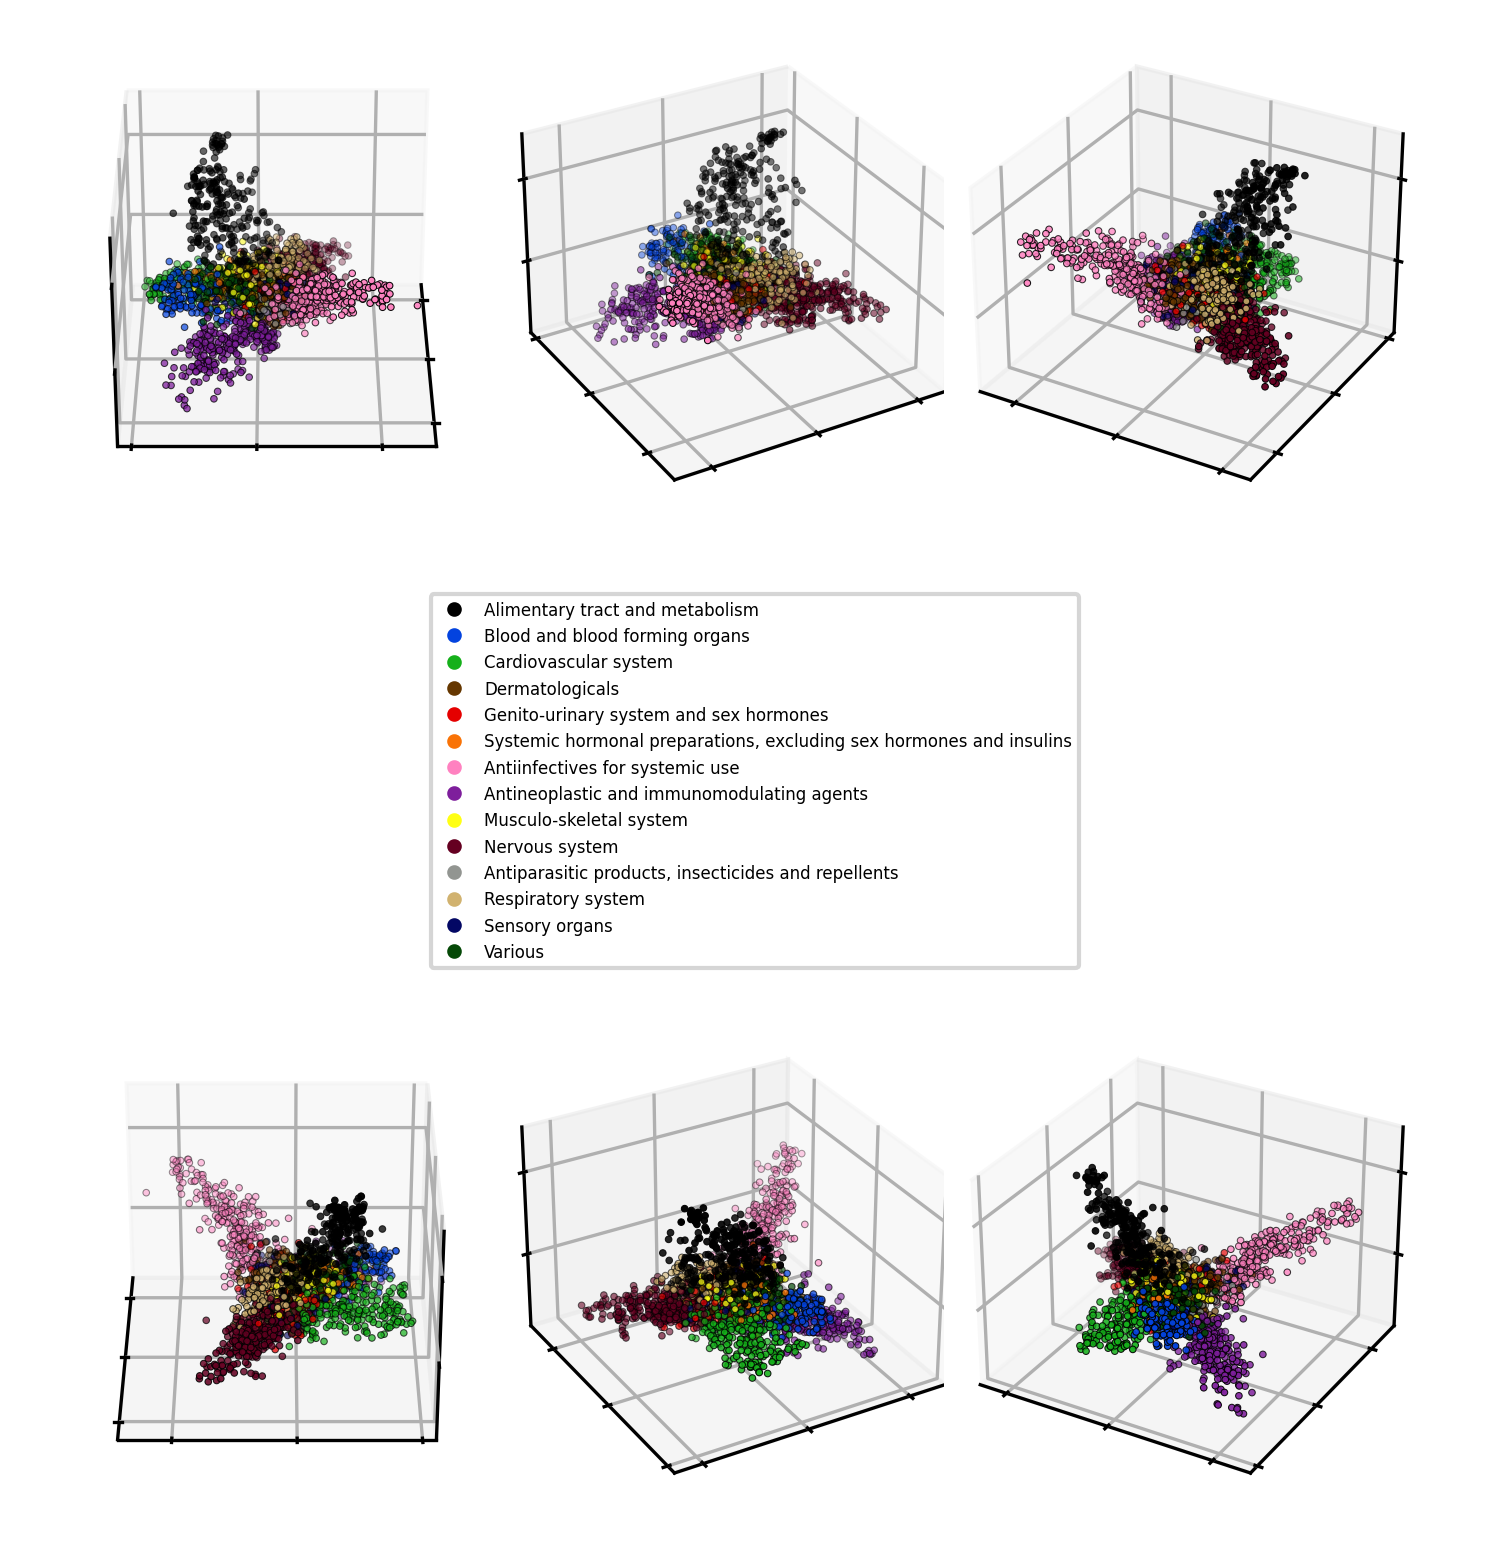

In [360]:
# Perform PCA on drug embeddings and plot on 3D axes with coloring according to first-level ATC categorization

from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

pca = decomposition.PCA(n_components=3)
pca.fit(pca_drug_emb)
X = pca.transform(pca_drug_emb)

fig = plt.figure(1, figsize=(6, 9), dpi=300)

ax = fig.add_subplot(231, projection='3d', elev=30, azim=0)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, edgecolor="k", s=2.5, linewidths=0.25)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax = fig.add_subplot(232, projection='3d', elev=30, azim=60)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, edgecolor="k", s=2.5, linewidths=0.25)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax = fig.add_subplot(233, projection='3d', elev=30, azim=120)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, edgecolor="k", s=2.5, linewidths=0.25)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax = fig.add_subplot(234, projection='3d', elev=30, azim=180)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, edgecolor="k", s=2.5, linewidths=0.25)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax = fig.add_subplot(235, projection='3d', elev=30, azim=240)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, edgecolor="k", s=2.5, linewidths=0.25)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax = fig.add_subplot(236, projection='3d', elev=30, azim=300)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, edgecolor="k", s=2.5, linewidths=0.25)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

legend_elements = [Line2D([0], [0], marker='o', linestyle='None', color=c, label=atc_map[a], markerfacecolor=c, markersize=2.5) for a,c in color_map.items()]
fig.legend(handles=legend_elements, loc="center", prop={'size': 4})
plt.subplots_adjust(hspace=-0.05, wspace=-0.05)
fig.show()